- Just as we know, CNN has limitations in capturing long-range contextual dependencies because it primarily relies on local receptive fields.
- This means that important spatial and channel-wise relationships might not be fully utilized.
- To overcome this, attention mechanisms have been introduced to help models selectively focus on the most relevant features.

# Attention Mechanisms in Computer Vision

Convolutional Block Attention Module (CBAM)  is an attention mechanism that helps CNNs focus on important features in both the channel and spatial dimensions. This workshop covers the implementation and understanding of CBAM using PyTorch.

**CBAM** consists of two sequential sub-modules:

- Channel Attention Module
- Spatial Attention Module

# Attention Modules
[Understanding Attention Modules](https://medium.com/visionwizard/understanding-attention-modules-cbam-and-bam-a-quick-read-ca8678d1c671)

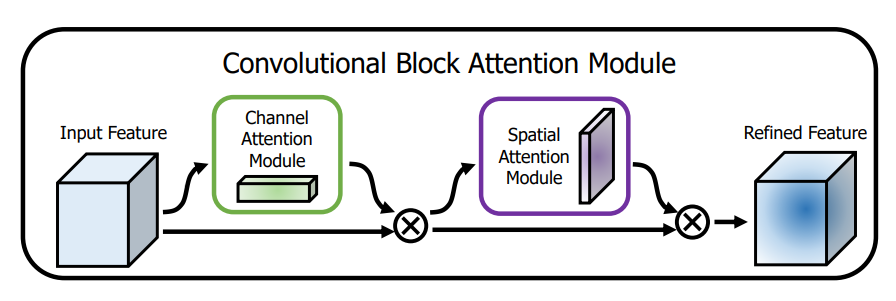

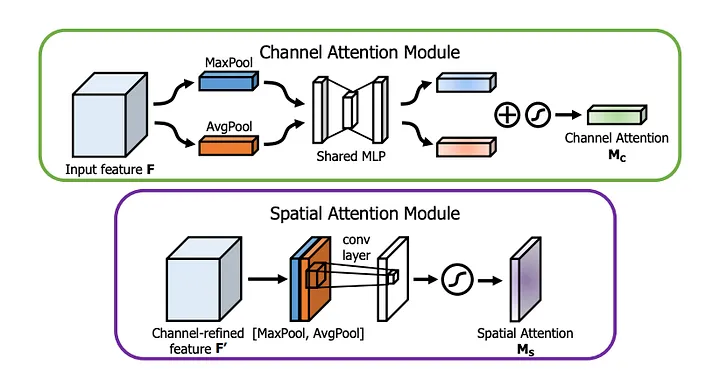

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(0)

# Channel Attention Module

Goal: Determine which channels are more important for the task, assign them higher weights, and suppress irrelevant channels.

**Key Components:**
- Average Pooling: Captures global average information
- Max Pooling: Captures most prominent features
- Combines max and average pooled features
- Sigmoid activation for attention weights

In [ ]:
# Define the Channel Attention Module
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1) # Calculate each channels avg and max value in order to let network focus on overall info of different channel
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // reduction_ratio, kernel_size=1), # C//r=1000/16=62
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // reduction_ratio, in_channels, kernel_size=1)
        )
        # self.fc = nn.Sequential(
        #     nn.Linear(in_channels, in_channels // reduction_ratio),
        #     nn.ReLU(inplace=True),
        #     nn.Linear(in_channels // reduction_ratio, in_channels)
        # )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x): # x=[B, C, H, W]
        avg_out = self.fc(self.avg_pool(x)) # [B, C, 1, 1]
        max_out = self.fc(self.max_pool(x)) # [B, C, 1, 1]
        out = avg_out + max_out
        return self.sigmoid(out)
        #return self.sigmoid(out) * x


# Spatial Attention Module


Goal: Identify which spatial locations are more important.


**Key Components:**
- Average pooling across channels
- Max pooling across channels
- Sigmoid activation for spatial attention map

In [ ]:
# Define the Spatial Attention Module
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size//2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True) # DIM is in the first dimension, which is after the batch size, so it is defined as [B,1,H,W].
        max_out, _ = torch.max(x, dim=1, keepdim=True) # [B, 1, H, W]
        x = torch.cat([avg_out, max_out], dim=1) # [B, 2, H, W]
        x = self.conv(x) # [B, 1, H, W]
        return self.sigmoid(x) # [B, 1, H, W] (final attention map)
        #return self.sigmoid(out) * x



In [ ]:
x = torch.rand(2, 3, 4)  # [B=2, C=3, H=4]
mean_x = torch.mean(x, dim=1)  # default keepdim=False
print(mean_x.shape)


torch.Size([2, 4])


# Convolutional Block Attention Module (CBAM)

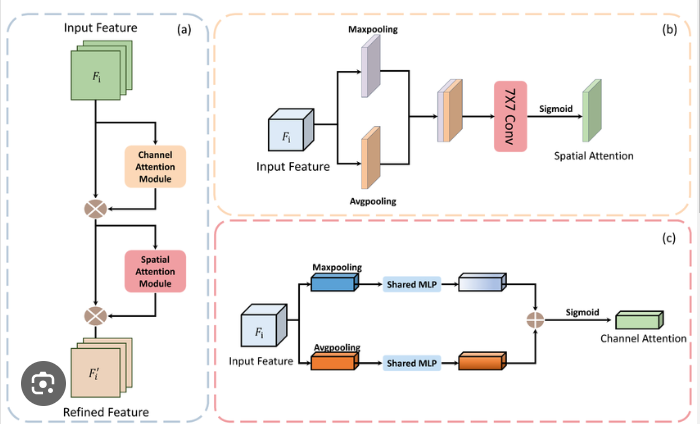

In [ ]:
# Define the CBAM-like Attention Module
class CBAMAttention(nn.Module):
    def __init__(self, in_channels):
        super(CBAMAttention, self).__init__()
        self.channel_att = ChannelAttention(in_channels)
        self.spatial_att = SpatialAttention()

    def forward(self, x):
        x = x * self.channel_att(x) # x* [B, C, 1, 1] = [B, C, H, W]
        x = x * self.spatial_att(x) # x * [B, 1, H, W] = [B, C, H, W]
        return x

# Integration with CNN
The provided code integrates CBAM with a basic CNN architecture:
- Standard convolutional layers
- CBAM module after feature extraction
- Classifier head with dropout

https://arxiv.org/abs/1807.06521

In [ ]:
# Define the CNN with CBAM-like Attention
class CNNWithCBAMAttention(nn.Module):
    def __init__(self, num_classes=10):
        super(CNNWithCBAMAttention, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.attention = CBAMAttention(128)
        self.classifier = nn.Sequential(
            nn.Linear(128 * 8 * 8, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.attention(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Training and Evaluation function
- Dataset: CIFAR-10 (subset used for faster training)
- Optimizer: Adam with learning rate 0.001
- Loss Function: CrossEntropyLoss

In [ ]:
# Training function
def train(model, epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_losses = []
    train_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_loss = running_loss / len(trainloader)
        epoch_acc = 100. * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        print(f'Epoch {epoch + 1}, Loss: {epoch_loss:.3f}, Accuracy: {epoch_acc:.2f}%')

    return train_losses, train_accuracies

In [ ]:
# Evaluation function
def evaluate(model):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    accuracy = 100. * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')
    return accuracy

# Data

In [ ]:
# Prepare CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# Use only 1/10 of the data
train_indices = torch.randperm(len(trainset))[:len(trainset) // 10]
trainset = torch.utils.data.Subset(trainset, train_indices)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)


testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
# Use only 1/10 of the data
test_indices = torch.randperm(len(testset))[:len(testset) // 10]
testset = torch.utils.data.Subset(testset, test_indices)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True, num_workers=2)


100%|██████████| 170M/170M [00:03<00:00, 56.4MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Model training

In [ ]:
# Initialize the model, loss function, and optimizer
model = CNNWithCBAMAttention()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch 1, Loss: 2.052, Accuracy: 24.46%
Epoch 2, Loss: 1.732, Accuracy: 35.54%
Epoch 3, Loss: 1.571, Accuracy: 42.72%
Epoch 4, Loss: 1.473, Accuracy: 46.36%
Epoch 5, Loss: 1.354, Accuracy: 51.32%
Epoch 6, Loss: 1.280, Accuracy: 54.08%
Epoch 7, Loss: 1.206, Accuracy: 57.48%
Epoch 8, Loss: 1.127, Accuracy: 59.42%
Epoch 9, Loss: 0.996, Accuracy: 63.84%
Epoch 10, Loss: 0.950, Accuracy: 65.80%


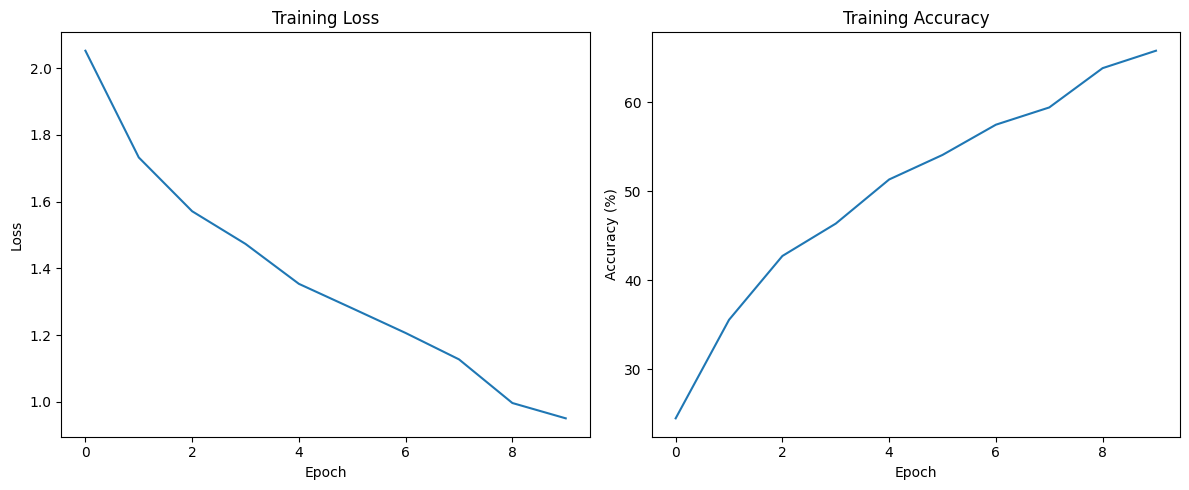

In [ ]:
# Train the model
losses, accuracies = train(model)

# Plot training loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(accuracies)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate the model
test_accuracy = evaluate(model)

Test Accuracy: 56.30%


# Visualize attention

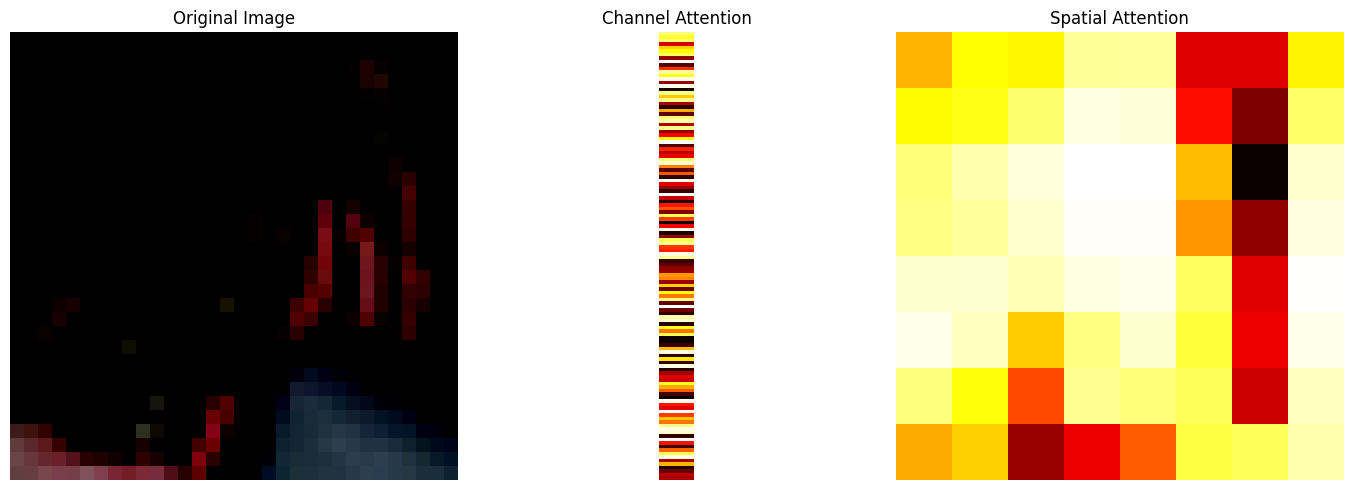

In [ ]:
import numpy as np

# Visualize attention
def visualize_attention(model, image):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    image = image.unsqueeze(0).to(device)

    with torch.no_grad():
        features = model.features(image)
        channel_att = model.attention.channel_att(features)
        spatial_att = model.attention.spatial_att(features)

    # Handle channel attention visualization
    channel_att = channel_att.squeeze().cpu().numpy()
    if channel_att.ndim == 0:  # scalar
        channel_att = np.full((10, 10), channel_att)
    elif channel_att.ndim == 1:  # 1D array
        channel_att = np.tile(channel_att[:, np.newaxis], (1, 10))
    elif channel_att.ndim == 3:  # 3D array
        channel_att = channel_att.mean(axis=0)


    spatial_att = spatial_att.squeeze().cpu().numpy()

    # Ensure spatial_att is 2D
    if spatial_att.ndim != 2:
        spatial_att = spatial_att.mean(axis=0) if spatial_att.ndim > 2 else np.full((10, 10), spatial_att)

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(image.squeeze().permute(1, 2, 0).cpu().numpy())
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(channel_att, cmap='hot')
    plt.title('Channel Attention')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(spatial_att, cmap='hot')
    plt.title('Spatial Attention')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize attention for a sample image
sample_image, _ = next(iter(testloader))
visualize_attention(model, sample_image[0])